Following https://www.tensorflow.org/tutorials/images/transfer_learning tutorial

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Step 1: Loading in Dataset
ds_directory = '/home/zrarnz/9-Projects/ECET380/Fish_Dataset/fishset2'
os.listdir(ds_directory)

['Sea Bass',
 'Trout',
 'Striped Red Mullet',
 'README.txt',
 'Hourse Mackerel',
 'Red Sea Bream',
 'Black Sea Sprat',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Mullet',
 'Segmentation_example_script.m',
 'license.txt']

In [17]:
# Load in ordered dataset
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
dataset = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')


Found 9000 files belonging to 9 classes.


In [18]:
dataset.class_names

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [19]:
DATASET_SIZE = 9000

In [20]:
train_size = int(0.7 * float(DATASET_SIZE / BATCH_SIZE))
val_size = int(0.15 * float(DATASET_SIZE / BATCH_SIZE))
test_size = int(0.15 * float(DATASET_SIZE / BATCH_SIZE))

# dataset = dataset.shuffle(1000)
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)
val_set = test_set.take(val_size)
test_set = test_set.skip(val_size)

print(train_size, val_size, test_size)

393 84 84


In [21]:
batch_size = 16
def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.efficientnet.preprocess_input(image)
    return final_image, label
train_set = train_set.shuffle(1000).repeat(2)
train_set = train_set.map(preprocess).prefetch(1)
val_set = val_set.map(preprocess).prefetch(1)
test_set = test_set.map(preprocess).prefetch(1)

In [23]:
print('Number of dataset batches: %d' % tf.data.experimental.cardinality(dataset))
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))


print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of dataset batches: 563
Number of fullset batches: 786
Number of validation batches: 84
Number of test batches: 86


In [22]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                                  input_tensor=None,
                                               include_top=False,
                                               pooling=None,
                                                classes=1000,
                                               weights='imagenet')

In [24]:
for layer in base_model.layers:
    layer.trainable = False

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(
    units = 9, 
    activation = "softmax")(avg)

model = keras.models.Model(
    inputs = base_model.input,
    outputs = output)

model.compile(
    optimizer = keras.optimizers.SGD(
        learning_rate = 0.01,
        ),
    loss = "sparse_categorical_crossentropy", 
    metrics = ['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [25]:
# tuner = kt.RandomSearch(
#             model_builder,
#             objective='val_accuracy',
#             max_trials=27,
#             seed=0,
#             overwrite=True,
#             executions_per_trial=2)

In [26]:
pre_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
pre_chckp = keras.callbacks.ModelCheckpoint("effdetb0_fish_pretune.h5", save_best_only=True)

In [ ]:
model.fit(train_set,
            validation_data=val_set,
            epochs=22,
            callbacks=[pre_early, pre_chckp],
#             steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
#             validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
            )

Epoch 1/22


In [ ]:
model.evaluate(test_set)

In [3]:
# Load in ordered dataset
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
DATASET_SIZE = 9000
IMG_SHAPE = IMG_SIZE + (3,)
dataset = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')
train_size = int(0.7 * float(DATASET_SIZE / BATCH_SIZE))
val_size = int(0.15 * float(DATASET_SIZE / BATCH_SIZE))
test_size = int(0.15 * float(DATASET_SIZE / BATCH_SIZE))

# dataset = dataset.shuffle(1000)
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)
val_set = test_set.take(val_size)
test_set = test_set.skip(val_size)

print(train_size, val_size, test_size)

batch_size = 16
def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.efficientnet.preprocess_input(image)
    return final_image, label
train_set = train_set.shuffle(1000).repeat(2)
train_set = train_set.map(preprocess).prefetch(1)
val_set = val_set.map(preprocess).prefetch(1)
test_set = test_set.map(preprocess).prefetch(1)

Found 9000 files belonging to 9 classes.
393 84 84


In [4]:
print('Number of dataset batches: %d' % tf.data.experimental.cardinality(dataset))
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))


print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of dataset batches: 563
Number of fullset batches: 786
Number of validation batches: 84
Number of test batches: 86


In [8]:
model2 = keras.models.load_model("003_effdetb0_fish_pretune.h5")

In [9]:
for layer in model2.layers:
        layer.trainable=True

In [10]:
optimizer2 = keras.optimizers.SGD(learning_rate=0.002)

In [11]:
post_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
post_chckp = keras.callbacks.ModelCheckpoint("effdetb0_fish_posttune.h5", save_best_only=True)

In [12]:
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer2,
    metrics="accuracy"
)

In [13]:
history = model2.fit(
    train_set,
    validation_data=val_set,
    epochs=64,
    callbacks=[post_early, post_chckp]
)

Epoch 1/64
786/786 [==============================] - 402s 375ms/step - loss: 0.5329 - accuracy: 0.8814 - val_loss: 0.0565 - val_accuracy: 0.9985
Epoch 2/64
786/786 [==============================] - 413s 398ms/step - loss: 0.1132 - accuracy: 0.9874 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 3/64
786/786 [==============================] - 443s 421ms/step - loss: 0.0710 - accuracy: 0.9906 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 4/64
786/786 [==============================] - 428s 412ms/step - loss: 0.0524 - accuracy: 0.9931 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 5/64
786/786 [==============================] - 428s 413ms/step - loss: 0.0400 - accuracy: 0.9955 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 6/64
786/786 [==============================] - 429s 416ms/step - loss: 0.0315 - accuracy: 0.9972 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 7/64
786/786 [==============================] - 428s 415ms/step - loss: 0.0239 - accuracy: 0.9976 - val_loss: 0.0037 -

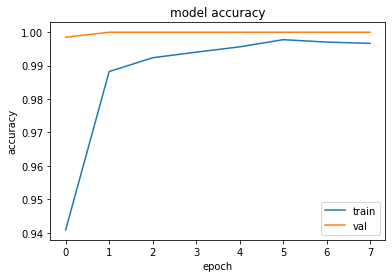

In [14]:
fig_acc = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [15]:
model2.evaluate(test_set)

86/86 [==============================] - 70s 124ms/step - loss: 0.0227 - accuracy: 1.0000


[0.02272276021540165, 1.0]

In [16]:
evalPipe=test_set
for feats,lab in evalPipe.unbatch().batch(6000).take(1):
	probPreds=model2.predict(feats)

top1err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=1))
top5err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=5))
top10err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=10))
print(top10err, top5err, top1err)

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
